<a href="https://colab.research.google.com/github/PaudelSiddhanta/Rectangular_EIT/blob/main/Rectangular_NN_custom_grad_and_adam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import numpy as np
from rect_grid import Node, GridStructure
import solve_linear as sl
import torch
import torch.nn as nn
import math
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
import copy

In [ ]:

# Define the neural network architecture for rectangular network
class SquareEITNN(nn.Module):
    def __init__(self, grid):
        super(SquareEITNN, self).__init__()
        self.grid = grid
        self.n = grid.n
        self.input_size = 8 * self.n
        self.hidden_size = self.n **2 + 8* self.n
        self.output_size = self.n **2 + 4* self.n
        self.interior_size = self.n **2
        self.neumann_copy_start = self.n **2 +4*self.n


        # Initialize W1 as a single Parameter matrix
        self.W1 = nn.Parameter(torch.zeros(self.hidden_size, self.input_size, dtype = torch.float64, requires_grad = False))
        self.W1_fixed = torch.zeros(self.hidden_size, self.input_size, dtype=torch.float64)
        # W1_fixed_mask: True means fixed (non-trainable), False means trainable
        self.W1_fixed_mask = torch.ones(self.hidden_size, self.input_size, dtype=torch.bool)
        self.W1_fixed_mask[:self.interior_size, :4*self.n] = False  # Make top left n^2 by 4n matrix trainable


        self.W1__grad = torch.zeros(self.hidden_size,self.input_size,dtype = torch.float64, requires_grad = False)
        self.W2__grad = torch.zeros(self.output_size,self.hidden_size,dtype = torch.float64, requires_grad = False)
        self._initialize_W1_blocks()
        self._initialize_W2()
        # self.register_buffer('W1_mask', (~self.W1_fixed_mask).float())


    # ## currently being worked on
    def assign_gradients(self, x_data, h,y, alpha): #,batch_size = 4*self.n):
        """
            x_data: train dataset
            h: hidden layer
            y: the output matrix
            alpha: the tradeoff parameter between interior and boundary currents
            batch_size =  number of DtN data used to train the parameter
        """
        with torch.no_grad():
            batch_size = y.shape[0]
            dL_dy = torch.zeros_like(y)  # shape :(batch_size,n^2+4n)
            dL_dy[:, :n**2] = alpha * y[:, :n**2] / batch_size
            dL_dy[:, n**2:] = y[:, n**2:] / batch_size

            dW1 = torch.zeros(self.hidden_size,self.input_size,dtype = torch.float64,requires_grad = False)
            dW2 = torch.zeros(self.output_size,self.hidden_size,dtype = torch.float64,requires_grad = False)

             # Gradient w.r.t. W2_dynamic

            dW2 = dL_dy.T @ h  # shape: (n^2 + 4n, n^2 + 8n)
            grad = {}
            w2_indices = [(i, j) for i in range(self.n**2) for j in self.grid.get_node_by_index(i).neighbors if i < j < self.interior_size + 4*self.n]
            for i, j in w2_indices:
                grad[(i, j)] = dW2[i, j] + dW2[j, i] - dW2[i, i] - dW2[j, j]
                self.W2__grad[i, j] = grad[(i, j)] / (1 + self.Beta[i, j]**2)
                #the factor of 1/(1+beta^2) is due to the transform we used.
            #the term W2__grad is actually the gradient of Beta.


            dW1 =self.W2_dynamic.T @ dL_dy.T @ x_data
            for i in range(self.n**2):
                for j in range(4*self.n):
                    self.W1__grad[i,j] = dW1[i,j]


    def _initialize_W1_blocks(self):
        # A: random positive (n^2 by 4n)
        #Xavier initialization
        with torch.no_grad():
            self.W1[:self.interior_size, :4*self.n] = torch.randn(self.interior_size, 4*self.n) #* (1/self.interior_size*4*self.n)


            # D: zeros n^2 by 4n
            self.W1[:self.interior_size, 4*self.n:] = 0.0

            self.W1_fixed[:self.interior_size, 4*self.n:] = 0.0

            # B: identity 4n x 4n
            self.W1[self.interior_size:self.interior_size + 4*self.n, :4*self.n] = torch.eye(4*self.n)
            self.W1_fixed[self.interior_size:self.interior_size + 4*self.n, :4*self.n] = torch.eye(4*self.n)

            # C: zeros 4n x 4n
            self.W1[self.interior_size:self.interior_size + 4*self.n, 4*self.n:] = 0.0
            self.W1_fixed[self.interior_size:self.interior_size + 4*self.n, 4*self.n:] = 0.0

            # C: zeros 4n x 4n (bottom left block)
            self.W1[self.interior_size + 4*self.n:, :4*self.n] = 0.0
            self.W1_fixed[self.interior_size + 4*self.n:, :4*self.n] = 0.0

            # B: identity 4n x 4n (bottom right block)
            self.W1[self.interior_size + 4*self.n:, 4*self.n:] = torch.eye(4*self.n)
            self.W1_fixed[self.interior_size + 4*self.n:, 4*self.n:] = torch.eye(4*self.n)

        #initializing W1 and W1 fixed might be redundant but still we proceed with it.

    def _initialize_W2(self):
        size_out = self.output_size
        size_hidden = self.hidden_size

        self.Beta = nn.Parameter(torch.zeros(size_out, size_hidden, dtype=torch.float64, requires_grad = False))
        self.W2_fixed = torch.zeros(size_out, size_hidden, dtype=torch.float64)
        self.W2_mask = torch.ones(size_out, size_hidden, dtype=torch.bool)

        with torch.no_grad():
            for i in range(self.interior_size):

                node_i = self.grid.get_node_by_index(i)
                neighbor_indices = [j for j in node_i.neighbors if i < j < self.interior_size + 4*self.n]
                weights = torch.abs(torch.randn(len(neighbor_indices), dtype=torch.float64))# * (1/len(neighbor_indices)) #xavier initialization to avoid vanishing gradient


                for k, j in enumerate(neighbor_indices):
                    self.Beta[i,j] = weights[k]
                    #eventhough we make beta symmetric , this is not necessary at the start, we just start with the proper conditions at the start
                    self.Beta[j, i] = weights[k]


                    # self.W2_fixed[i,j] = weights[k]
                    self.W2_fixed[j, i]=weights[k]
                    self.W2_mask[i, j] = False
                    # self.W2_mask[j,i] = False

                self.Beta[i, i] = 0
                self.W2_fixed[i, i] = 0

            for i in range(self.interior_size+4*self.n):
                #not requured for beta but doesnt matter for initialization
                self.Beta[i, i] = -torch.sum(torch.tensor([self.Beta[i, j] for j in range(self.interior_size+4*self.n)]))
                self.W2_fixed[i, i] = -torch.sum(torch.tensor([self.W2_fixed[i, j] for j in range(self.interior_size+4*self.n)]))

            #### weight of -1 doesn't work since we symmetrized the matrix
            for i in range(4*self.n):
                row = self.interior_size + i
                col = self.neumann_copy_start + i
                self.Beta[row, col] = 1.0
                self.W2_fixed[row, col] = 1.0


    def symmetrize_W2_after_training(self):

        with torch.no_grad():
        #enforce symmetry in W2_DYNAMIC:
          for i in range(self.interior_size):
              node_i = self.grid.get_node_by_index(i)
              neighbor_indices = [j for j in node_i.neighbors if i < j < self.interior_size + 4*self.n]
              for k, j in enumerate(neighbor_indices):
                  self.W2_fixed[i,j] = self.transform(self.Beta[i,j])  # this step is necessary to calculate the i,i node
                  self.W2_fixed[j,i] = self.transform(self.Beta[i,j]) #enforce symmetry
          #enforcing Kirchoff's lawsd
          for i in range(self.interior_size+4*self.n):
              self.W2_fixed[i, i] = 0
              self.W2_fixed[i, i] = -torch.sum(torch.tensor([self.W2_fixed[i, j] for j in range(self.interior_size+4*self.n)]))


    # def test(self,x)
    def transform(self,x): #always generates a positive value
        return torch.arctan(x)+torch.pi/2

    def forward(self, x):
       # we use the idea conductivity = f(beta) where f  = arctan +pi/2

        self.W1_dynamic = torch.where(self.W1_fixed_mask, self.W1_fixed, self.W1)
        self.W2_dynamic = torch.where(self.W2_mask, self.W2_fixed, torch.arctan(self.Beta)+torch.pi/2)  # now it’s connected to Beta
        #W2 dynamic is still not symmetric. we need to symmetrize it.
        # self.symmetrize_W2_after_training()
        hid = torch.matmul(x,self.W1_dynamic.t())
        outp = torch.matmul(hid, self.W2_dynamic.t())
        # print("shape of W1_dynamic",self.W1_dynamic.shape)
        # print("W1, dynamic.T = ",self.W2_dynamic.t())

        return outp,hid



In [ ]:
def generate_dtn_data(grid, batch_size):
    dirichlet = torch.zeros((batch_size, 4*grid.n), dtype=torch.float64)
    neumann = torch.zeros((batch_size, 4*grid.n), dtype=torch.float64)

    for k in range(min(batch_size, 4*grid.n)):
        dirichlet_data = {idx: 1.0 if idx == grid.boundary_index[k] else 0.0
                          for idx in grid.boundary_index}
        potentials, neumann_data = grid.solve_forward_problem(dirichlet_data)
        dirichlet[k, k] = 1.0
        for j, idx in enumerate(grid.boundary_index):
            neumann[k, j] = neumann_data[idx]

    data = torch.cat((dirichlet, neumann), dim=1)            #
    # return data, conductivities
    return data

def loss_function(output,grid, alpha=1.0):
    batch_size = output.size(0)
    interior = output[:, :-4*grid.n]
    boundary = output[:, -4*grid.n:]
    lss = (alpha* torch.sum(interior ** 2) +  torch.sum(boundary ** 2)) / (2 * batch_size)

    return lss

In [ ]:

def adam(param, grad, alpha, m_t, v_t, beta1, beta2, eps, time_step):
    with torch.no_grad():
        if grad is None:
            grad = torch.zeros_like(param)

        m_t1 = beta1 * m_t + (1 - beta1) * grad
        v_t1 = beta2 * v_t + (1 - beta2) * (grad ** 2)
        m_corr = m_t1 / (1 - beta1 ** time_step)
        v_corr = v_t1 / (1 - beta2 ** time_step)
        param = param - alpha * m_corr / (torch.sqrt(v_corr) + eps)
        return param, m_t1, v_t1


In [ ]:

def train_model_adam(num_epoch, dataloader, model, alpha, learning_rate, grid,
                beta1=0.9, beta2=0.99, eps=1e-8, patience=500, init_delta_thresh=1e-4,update_step=4000):

    num_epochs = num_epoch
    loss_record = []

    # Initialize Adam states
    adam_states = []
    model_grad = [model.W1__grad,model.W2__grad]
    model_param = [model.W1,model.Beta]
    name = ['W1','Beta']
    i  = 0
    for param,grad in zip(model_param,model_grad):
        m_t = torch.zeros_like(param)
        v_t = torch.zeros_like(param)
        adam_states.append({'name':name[i],'param': param, 'm': m_t, 'v': v_t,'param_grad':grad})
        i+=1

    t = 1  # Adam timestep
    best_loss = float('inf')
    delta_thresh = init_delta_thresh
    epochs_since_improvement = 0

    min_lr = 1e-8
    max_beta1 = 0.9995
    max_beta2 = 0.9999

    for epoch in range(num_epochs):
        for batch_x in dataloader:
            model.zero_grad()
            output,hid = model(batch_x)
            loss = loss_function(output, grid, alpha)
            # this is equivalent of loss.backward()
            model.assign_gradients(batch_x, hid ,output, alpha)

            #this is equivalent of optimizer.step()
            for state in adam_states:
                param = state['param']
                grad = state['param_grad']
                m = state['m']
                v = state['v']
                new_param, new_m, new_v = adam(param, grad, learning_rate, m, v, beta1, beta2, eps, t)
                param.data = new_param.data
                state['m'] = new_m
                state['v'] = new_v
            t += 1

            model.symmetrize_W2_after_training()

            if epoch+1 %update_step == 0:
                learning_rate = max(learning_rate * 0.01, min_lr)
                # beta1 = min(beta1 + 0.01, max_beta1)
                # beta2 = min(beta2 + 0.001, max_beta2)

        # # Plateau detection and strategy
        # if epochs_since_improvement >= patience:
        #     print(f"[Epoch {epoch+1}] Plateau detected. Adapting alpha, beta1, beta2 and delta_thresh.")

        #     # Reduce learning rate but don't go below min_lr
        #     if learning_rate > min_lr:
        #         learning_rate = max(learning_rate * 0.5, min_lr)

        #     # Increase beta only if learning rate hasn't hit min_lr
        #     if learning_rate > min_lr:
        #         beta1 = min(beta1 + 0.01, max_beta1)
        #         beta2 = min(beta2 + 0.001, max_beta2)
        #     else:
        #         # Keep beta fixed at max values when learning rate is minimal
        #         beta1 = max_beta1
        #         beta2 = max_beta2

        #     # Keep delta_thresh fixed (commented out decay)
        #     # delta_thresh = max(delta_thresh * 0.1, 1e-12)

        #     epochs_since_improvement = 0  # Reset counter
        #     print(f"Updated α={learning_rate:.2e}, β1={beta1:.4f}, β2={beta2:.4f}, Δ={delta_thresh:.1e}")

        if (epoch + 1) % 1000 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.6e}')

    # ---- Final processing and printing ----
    recovered_gamma = model.W2_dynamic.detach().numpy()
    estimated_conductivities = {}
    for edge in grid.edges:
        p_idx, q_idx = edge
        if p_idx >= grid.node_count - grid.n:
            continue
        estimated_conductivities[edge] = recovered_gamma[p_idx, q_idx]

    original_conductivities = copy.deepcopy(grid.conductivities)

    print("\nConductivity Comparison Table")
    print(f"{'Edge':>10} | {'Estimated':>12} | {'True':>12}")
    print("-" * 38)
    for edge in grid.edges:
        if edge in estimated_conductivities:
            est = estimated_conductivities[edge]
            true = original_conductivities[edge]
            print(f"{str(edge):>10} | {est.item():12.6f} | {true.item():12.6f}")

    demo_grid = GridStructure(grid.n)
    demo_grid.conductivities = original_conductivities
    print("Original Conductivity")
    demo_grid.visualize_network()

    demo_grid2 = GridStructure(grid.n)
    demo_grid2.conductivities = estimated_conductivities
    print("Recovered Conductivity")
    demo_grid2.visualize_network()

    return loss_record, estimated_conductivities


In [ ]:
# n = 3
# batch_size = 4*n
# grid = GridStructure(n)
# data = generate_dtn_data(grid, batch_size)
# dataloader = DataLoader(data, batch_size=batch_size, shuffle=True)
# model = SquareEITNN(grid)
# alpha = 1
# num_epoch =60000
# learning_rate = 0.02

In [ ]:
# train_model_adam(num_epoch, dataloader, model, alpha, learning_rate, grid,
#                 beta1=0.9, beta2=0.99, eps=1e-8, patience=500, init_delta_thresh=1e-4)

In [ ]:
n = 2
batch_size = 4*n
grid1 = GridStructure(n)
data1 = generate_dtn_data(grid1, batch_size)
dataloader1 = DataLoader(data1, batch_size=batch_size, shuffle=True)
model1 = SquareEITNN(grid1)
alpha1 = 1
num_epoch1 =30000
learning_rate1 = 0.002
update_step1=4000

Epoch [1000/30000], Loss: 1.114012e+00
Epoch [2000/30000], Loss: 9.638256e-03
Epoch [3000/30000], Loss: 4.944437e-04
Epoch [4000/30000], Loss: 3.587477e-05
Epoch [5000/30000], Loss: 8.747089e-07
Epoch [6000/30000], Loss: 3.116057e-07
Epoch [7000/30000], Loss: 3.592181e-07
Epoch [8000/30000], Loss: 1.014720e-06
Epoch [9000/30000], Loss: 6.451345e-07
Epoch [10000/30000], Loss: 8.845262e-07
Epoch [11000/30000], Loss: 8.956802e-07
Epoch [12000/30000], Loss: 4.906468e-07
Epoch [13000/30000], Loss: 6.429926e-07
Epoch [14000/30000], Loss: 7.473808e-07
Epoch [15000/30000], Loss: 5.197111e-07
Epoch [16000/30000], Loss: 7.951621e-07
Epoch [17000/30000], Loss: 8.815905e-07
Epoch [18000/30000], Loss: 1.243088e-06
Epoch [19000/30000], Loss: 1.458955e-07
Epoch [20000/30000], Loss: 6.850171e-07
Epoch [21000/30000], Loss: 1.718497e-07
Epoch [22000/30000], Loss: 5.579094e-07
Epoch [23000/30000], Loss: 1.297392e-06
Epoch [24000/30000], Loss: 1.502483e-06
Epoch [25000/30000], Loss: 2.030563e-07
Epoch [26

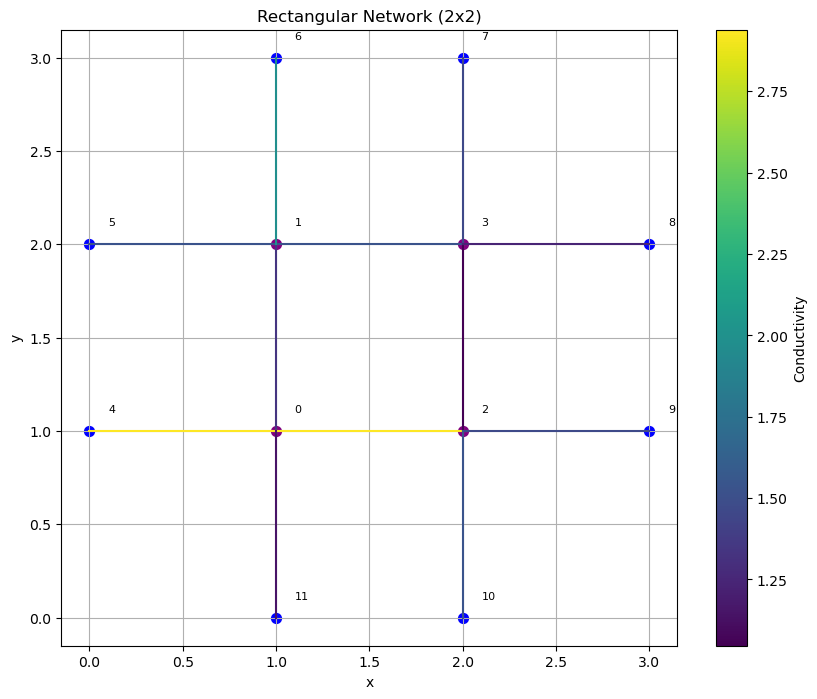

Recovered Conductivity


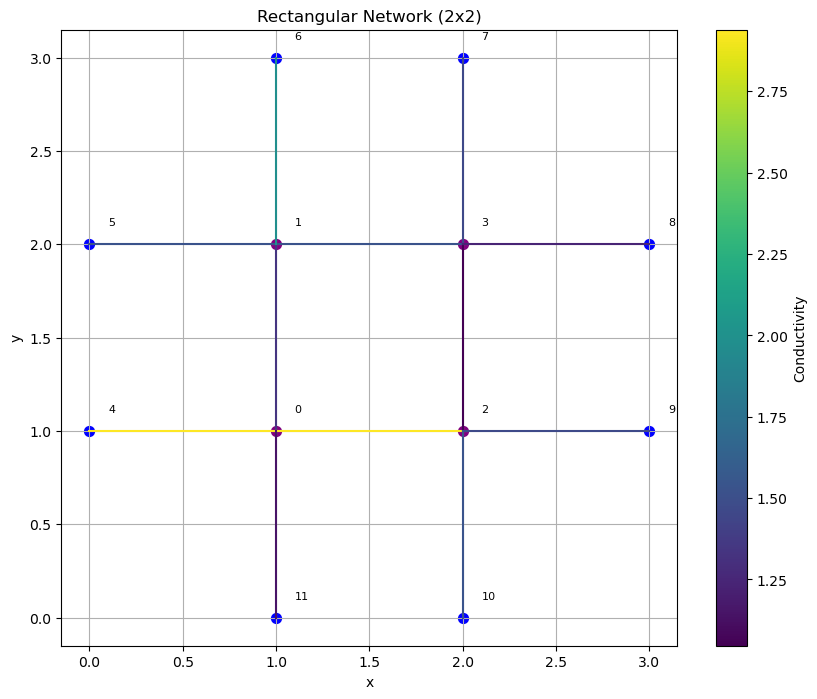

([],
 {(0, 1): 1.3405764656686547,
  (0, 2): 2.939332338600332,
  (0, 4): 2.9394725925383716,
  (0, 11): 1.145074761814079,
  (1, 3): 1.5271439748172029,
  (1, 5): 1.5270837322927457,
  (1, 6): 1.978144135616286,
  (2, 3): 1.046300919955685,
  (2, 9): 1.471585788562385,
  (2, 10): 1.5382705059856305,
  (3, 7): 1.4625244031374973,
  (3, 8): 1.2349046116389433})

In [ ]:
train_model_adam(num_epoch1, dataloader1, model1, alpha1, learning_rate1, grid1,
                beta1=0.9, beta2=0.99, eps=1e-8, patience=500, init_delta_thresh=1e-4,update_step=update_step1)

so the idea is to create a grad dictionary that stores the gradients of W2 and after we compute  
 dW2 = dL_dy.T @ h

        w2_indices = [(i, j) for i in range(n**2) for j in self.get_node_by_index(i).neighbors if i < j < n**2 + 4*n]

        for grad_idx, (i, j) in enumerate(w2_indices, start=w1_count):
        
            grad[grad_idx] = dW2[i, j] + dW2[j, i] - dW2[i, i] - dW2[j, j]

we update just the gradients, we dont need start= w1 count since we have only the gradients of trainable elements in grad. Then later we use this same gradient
to update the parameters

In [ ]:
n2 = 6
batch_size = 4*n2
grid3 = GridStructure(n2)
data3 = generate_dtn_data(grid3, batch_size)
dataloader3 = DataLoader(data3, batch_size=batch_size, shuffle=True)
model3 = SquareEITNN(grid3)
alpha3 = 1
num_epoch3 =30000
learning_rate3 = 0.02

Epoch [1000/30000], Loss: 9.421238e-02
Epoch [2000/30000], Loss: 1.351044e-03
Epoch [3000/30000], Loss: 5.930639e-04
Epoch [4000/30000], Loss: 7.914367e-04
Epoch [5000/30000], Loss: 1.009101e-03
Epoch [6000/30000], Loss: 8.577216e-04
Epoch [7000/30000], Loss: 5.918557e-04
Epoch [8000/30000], Loss: 5.975630e-04
Epoch [9000/30000], Loss: 5.458287e-04
Epoch [10000/30000], Loss: 5.925926e-04
Epoch [11000/30000], Loss: 7.765475e-04
Epoch [12000/30000], Loss: 6.796774e-04
Epoch [13000/30000], Loss: 9.283751e-04
Epoch [14000/30000], Loss: 1.030409e-03
Epoch [15000/30000], Loss: 1.044238e-03
Epoch [16000/30000], Loss: 9.578849e-04
Epoch [17000/30000], Loss: 6.820513e-04
Epoch [18000/30000], Loss: 1.579510e-03
Epoch [19000/30000], Loss: 1.489867e-03
Epoch [20000/30000], Loss: 1.549879e-03
Epoch [21000/30000], Loss: 5.461224e-04
Epoch [22000/30000], Loss: 8.868815e-04
Epoch [23000/30000], Loss: 9.668954e-04
Epoch [24000/30000], Loss: 1.413365e-03
Epoch [25000/30000], Loss: 8.464769e-04
Epoch [26

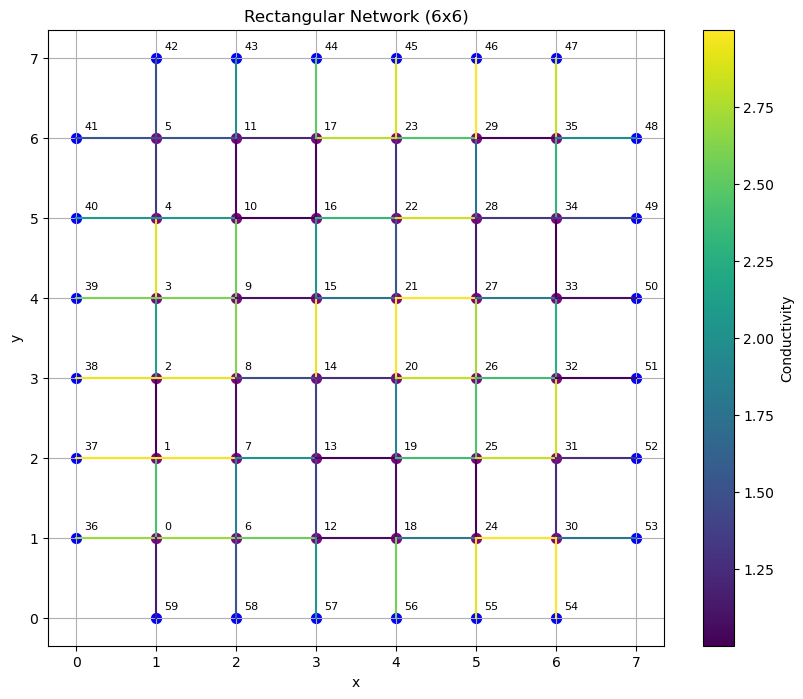

Recovered Conductivity


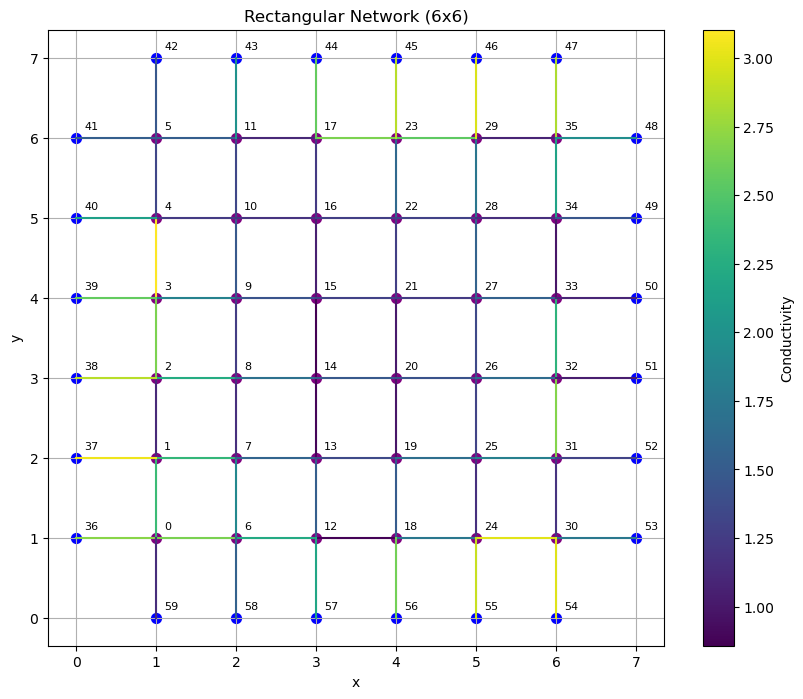

([],
 {(0, 1): 2.38586383268296,
  (0, 6): 2.649289821298944,
  (0, 36): 2.7056538248702546,
  (0, 59): 1.1450691519631402,
  (1, 2): 1.1144029341487487,
  (1, 7): 2.343721429008873,
  (1, 37): 3.0443312049685716,
  (2, 3): 2.6605419342407854,
  (2, 8): 2.241658227917289,
  (2, 38): 2.8602557373418276,
  (3, 4): 3.103206031153423,
  (3, 9): 1.8470352769097798,
  (3, 39): 2.563831788350075,
  (4, 5): 1.3257049822272462,
  (4, 10): 1.2518507124701763,
  (4, 40): 2.121516752461801,
  (5, 11): 1.5212513191665842,
  (5, 41): 1.5274464759197,
  (5, 42): 1.4687651213802333,
  (6, 7): 1.901245138230098,
  (6, 12): 2.218624828647773,
  (6, 58): 1.5541280517012834,
  (7, 8): 1.1629260521598037,
  (7, 13): 1.5800168356415552,
  (8, 9): 1.2580908995144835,
  (8, 14): 1.6848718089429229,
  (9, 10): 1.4751907176781234,
  (9, 15): 1.4423221693656492,
  (10, 11): 1.3368980632710579,
  (10, 16): 1.1910447858184976,
  (11, 17): 1.1103508968794547,
  (11, 43): 1.9942423250225034,
  (12, 13): 1.5285128298

In [ ]:
train_model_adam(num_epoch3, dataloader3, model3, alpha3, learning_rate3, grid3,
                beta1=0.9, beta2=0.99, eps=1e-8, patience=500, init_delta_thresh=1e-4,update_step=update_step1)

Let's try to recover conductivities for n=3 using less number of dtn Data
Define a function for that and loop through it to generate data

In [ ]:
def test_low_DTN(n):
    print("testing the data for n = ",n)
    max_batch_size = 4*n
    grid_rect = GridStructure(n)

    grid_rect.visualize_network()
    for i in range(max_batch_size-1,0,-1):
        model_test = SquareEITNN(grid_rect)
        print("number of DTN values used = ",i)
        data_small_batch = generate_dtn_data(grid_rect, i)
        print("training data used = ",data_small_batch)
        dataloader_batch = DataLoader(data_small_batch, batch_size=i, shuffle=True)
        alpha_train = 1
        num_epochs =30000
        learning_rate_train = 0.02
        update_step_test = 5000
        train_model_adam(num_epochs, dataloader_batch, model_test, alpha_train, learning_rate_train, grid_rect,
                beta1=0.9, beta2=0.99, eps=1e-8, patience=500, init_delta_thresh=1e-4,update_step=update_step_test)

        print()
        print()
        print(".................................................................................")

testing the data for n =  3


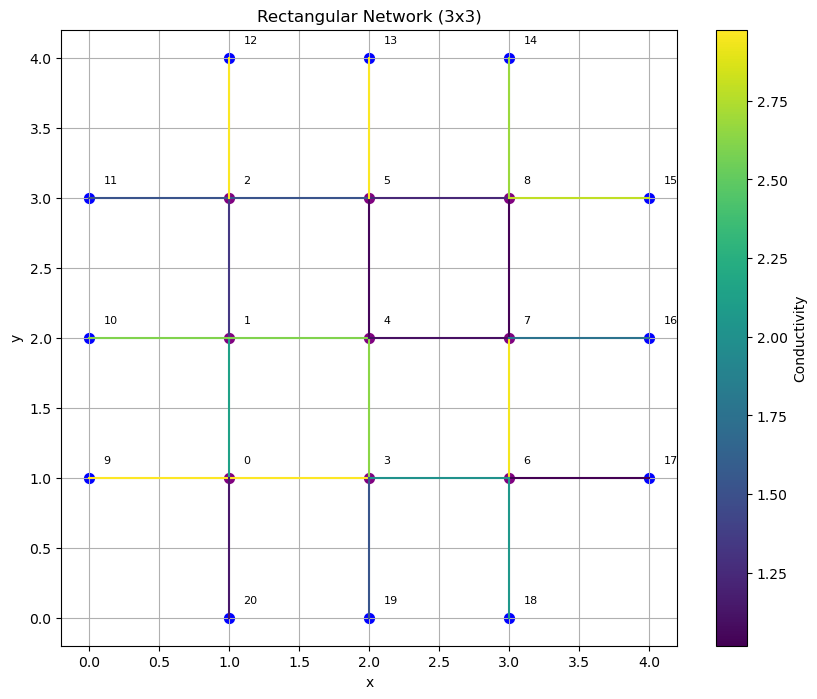

number of DTN values used =  11
training data used =  tensor([[ 1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  1.7364, -0.3819, -0.0502, -0.0974,
         -0.0878, -0.0308, -0.0320, -0.0897, -0.0667, -0.1352, -0.2878, -0.4769],
        [ 0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000, -0.3819,  1.5544, -0.1288, -0.2499,
         -0.1547, -0.0417, -0.0433, -0.0955, -0.0478, -0.0970, -0.1669, -0.1469],
        [ 0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000, -0.0502, -0.1288,  1.1778, -0.6779,
         -0.1739, -0.0288, -0.0300, -0.0184, -0.0082, -0.0166, -0.0259, -0.0193],
        [ 0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000, -0.0974, -0.2499, -0.6779,  1.6483,
         -0.3375, -0.0560, -0.0582, -0.0357, -0.0159

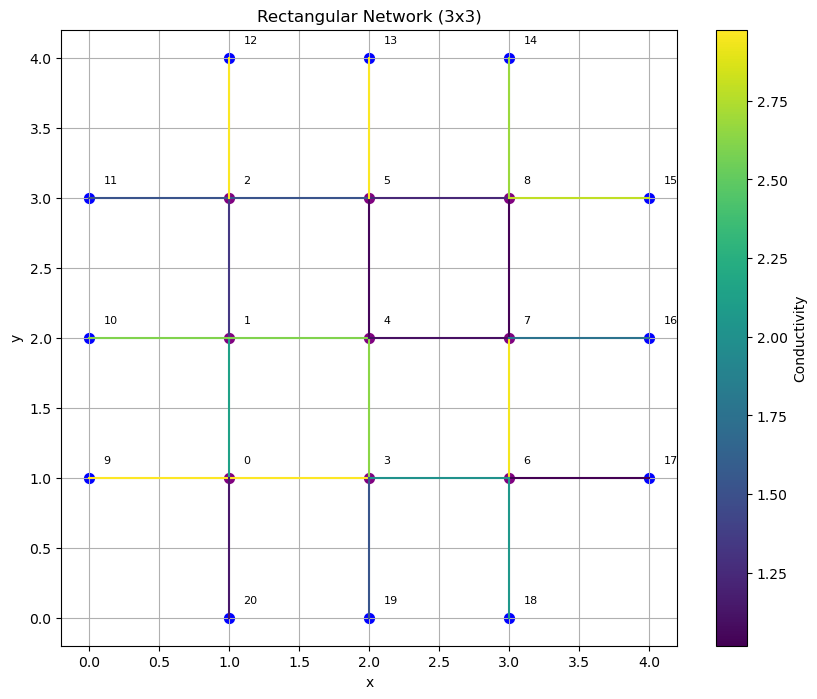

Recovered Conductivity


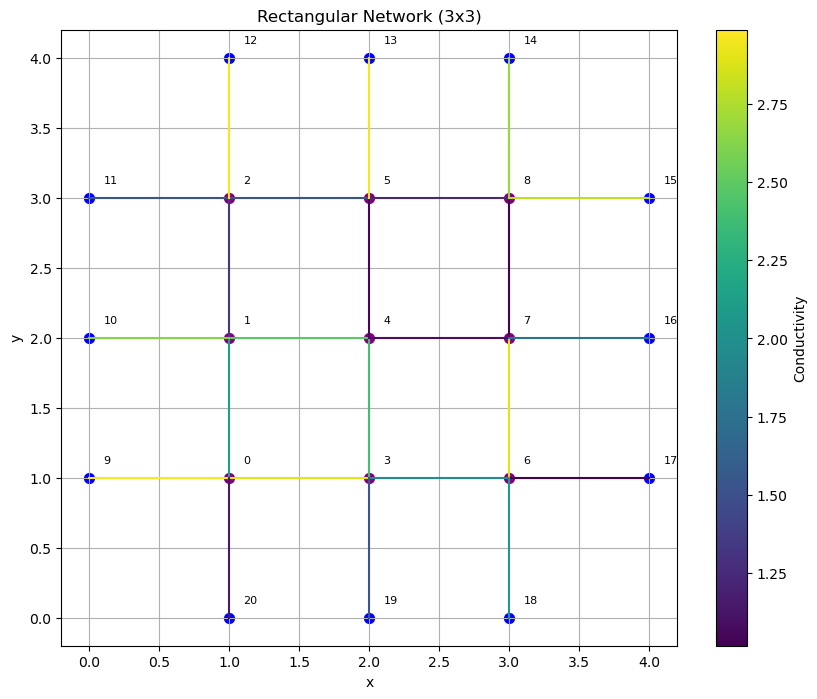



.................................................................................
number of DTN values used =  10
training data used =  tensor([[ 1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  1.7364, -0.3819, -0.0502, -0.0974,
         -0.0878, -0.0308, -0.0320, -0.0897, -0.0667, -0.1352, -0.2878, -0.4769],
        [ 0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000, -0.3819,  1.5544, -0.1288, -0.2499,
         -0.1547, -0.0417, -0.0433, -0.0955, -0.0478, -0.0970, -0.1669, -0.1469],
        [ 0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000, -0.0502, -0.1288,  1.1778, -0.6779,
         -0.1739, -0.0288, -0.0300, -0.0184, -0.0082, -0.0166, -0.0259, -0.0193],
        [ 0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000, -0.0

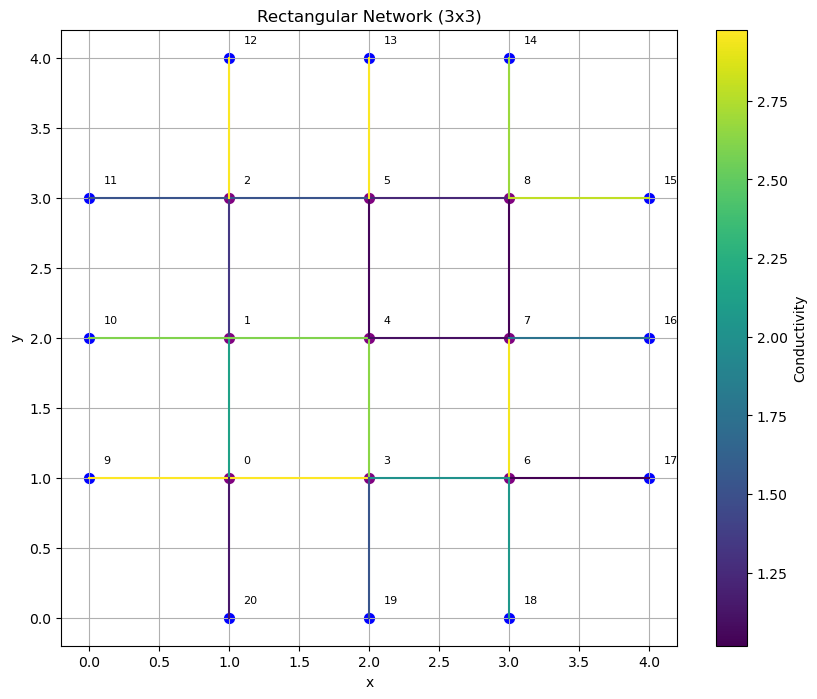

Recovered Conductivity


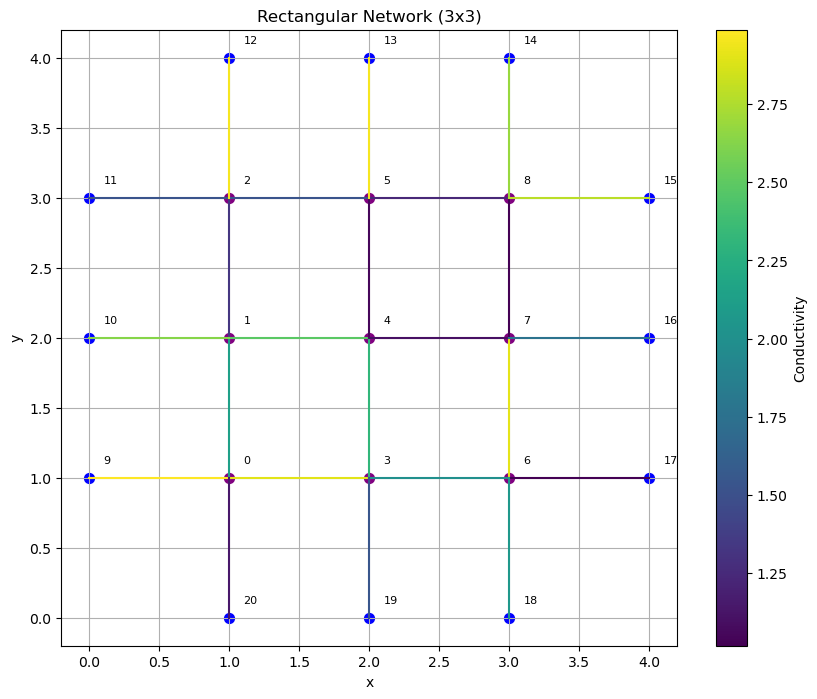



.................................................................................
number of DTN values used =  9
training data used =  tensor([[ 1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  1.7364, -0.3819, -0.0502, -0.0974,
         -0.0878, -0.0308, -0.0320, -0.0897, -0.0667, -0.1352, -0.2878, -0.4769],
        [ 0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000, -0.3819,  1.5544, -0.1288, -0.2499,
         -0.1547, -0.0417, -0.0433, -0.0955, -0.0478, -0.0970, -0.1669, -0.1469],
        [ 0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000, -0.0502, -0.1288,  1.1778, -0.6779,
         -0.1739, -0.0288, -0.0300, -0.0184, -0.0082, -0.0166, -0.0259, -0.0193],
        [ 0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000, -0.09

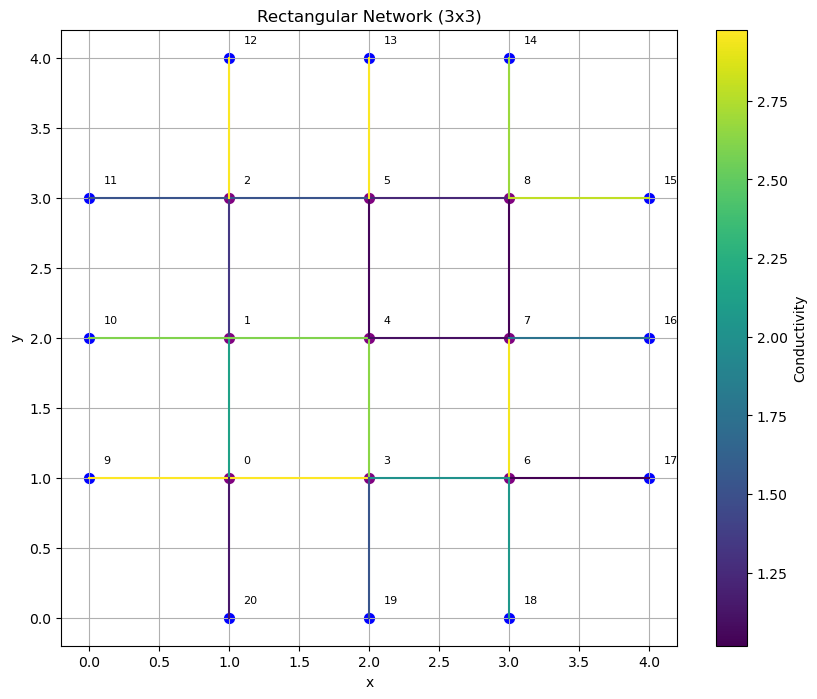

Recovered Conductivity


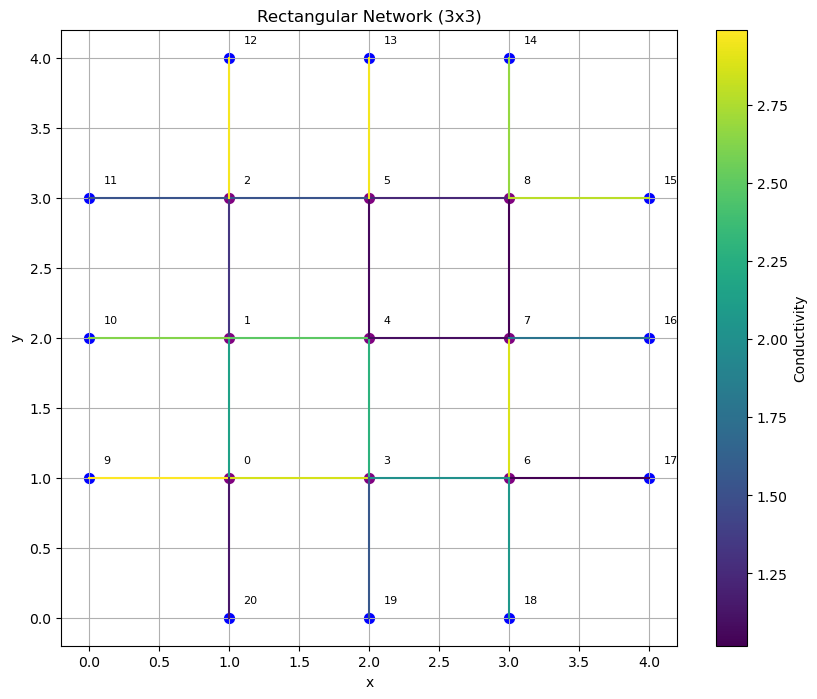



.................................................................................
number of DTN values used =  8
training data used =  tensor([[ 1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  1.7364, -0.3819, -0.0502, -0.0974,
         -0.0878, -0.0308, -0.0320, -0.0897, -0.0667, -0.1352, -0.2878, -0.4769],
        [ 0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000, -0.3819,  1.5544, -0.1288, -0.2499,
         -0.1547, -0.0417, -0.0433, -0.0955, -0.0478, -0.0970, -0.1669, -0.1469],
        [ 0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000, -0.0502, -0.1288,  1.1778, -0.6779,
         -0.1739, -0.0288, -0.0300, -0.0184, -0.0082, -0.0166, -0.0259, -0.0193],
        [ 0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000, -0.09

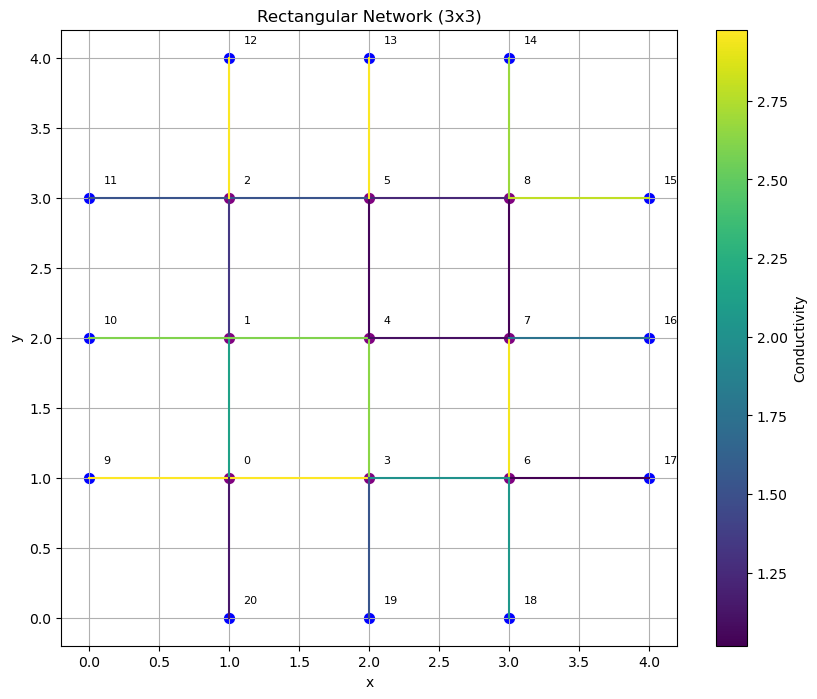

Recovered Conductivity


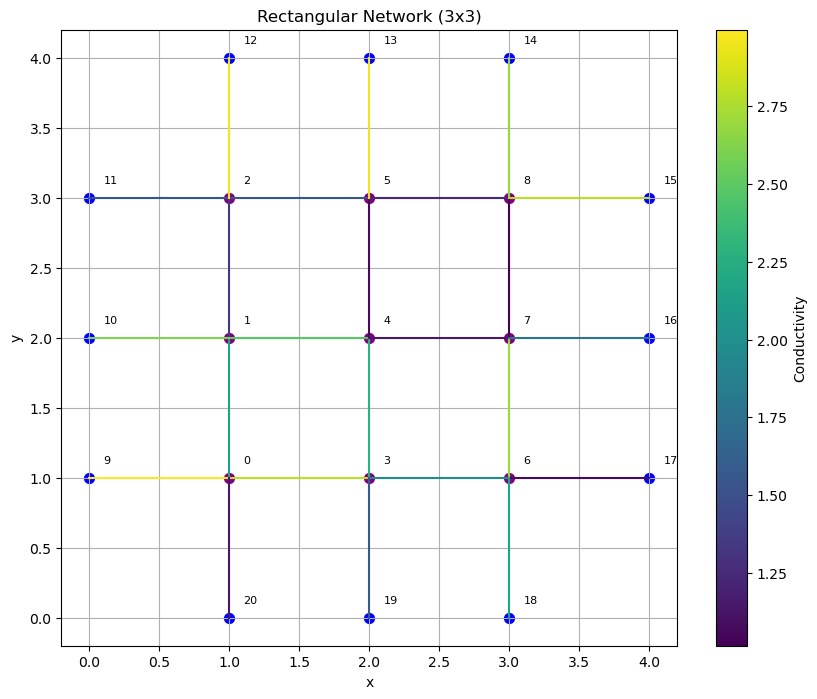



.................................................................................
number of DTN values used =  7
training data used =  tensor([[ 1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  1.7364, -0.3819, -0.0502, -0.0974,
         -0.0878, -0.0308, -0.0320, -0.0897, -0.0667, -0.1352, -0.2878, -0.4769],
        [ 0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000, -0.3819,  1.5544, -0.1288, -0.2499,
         -0.1547, -0.0417, -0.0433, -0.0955, -0.0478, -0.0970, -0.1669, -0.1469],
        [ 0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000, -0.0502, -0.1288,  1.1778, -0.6779,
         -0.1739, -0.0288, -0.0300, -0.0184, -0.0082, -0.0166, -0.0259, -0.0193],
        [ 0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000, -0.09

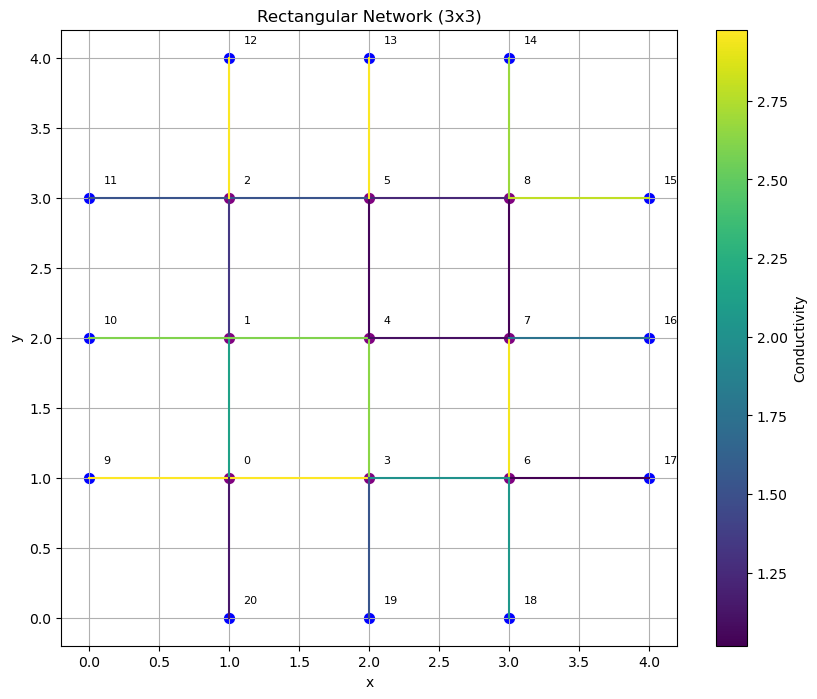

Recovered Conductivity


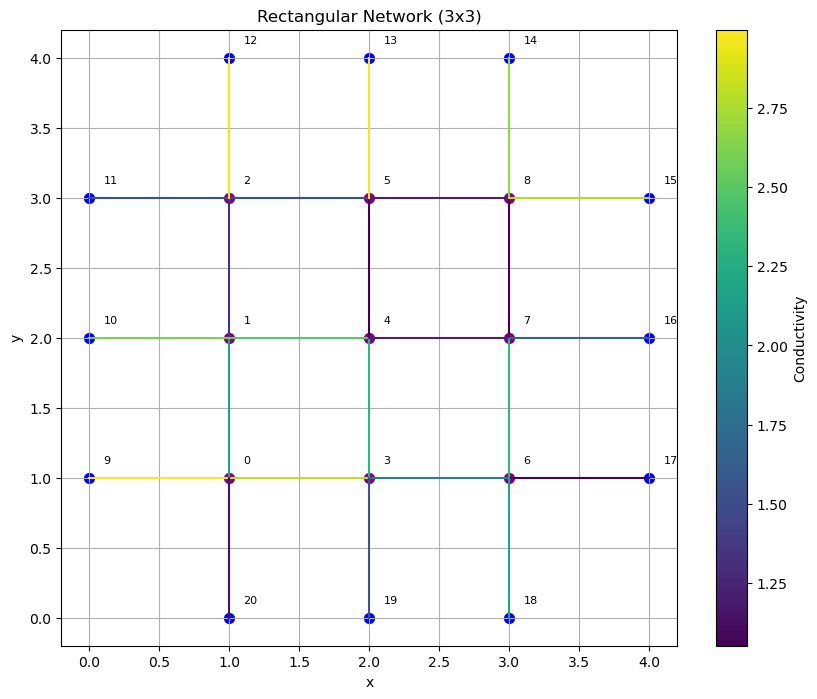



.................................................................................
number of DTN values used =  6
training data used =  tensor([[ 1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  1.7364, -0.3819, -0.0502, -0.0974,
         -0.0878, -0.0308, -0.0320, -0.0897, -0.0667, -0.1352, -0.2878, -0.4769],
        [ 0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000, -0.3819,  1.5544, -0.1288, -0.2499,
         -0.1547, -0.0417, -0.0433, -0.0955, -0.0478, -0.0970, -0.1669, -0.1469],
        [ 0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000, -0.0502, -0.1288,  1.1778, -0.6779,
         -0.1739, -0.0288, -0.0300, -0.0184, -0.0082, -0.0166, -0.0259, -0.0193],
        [ 0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000, -0.09

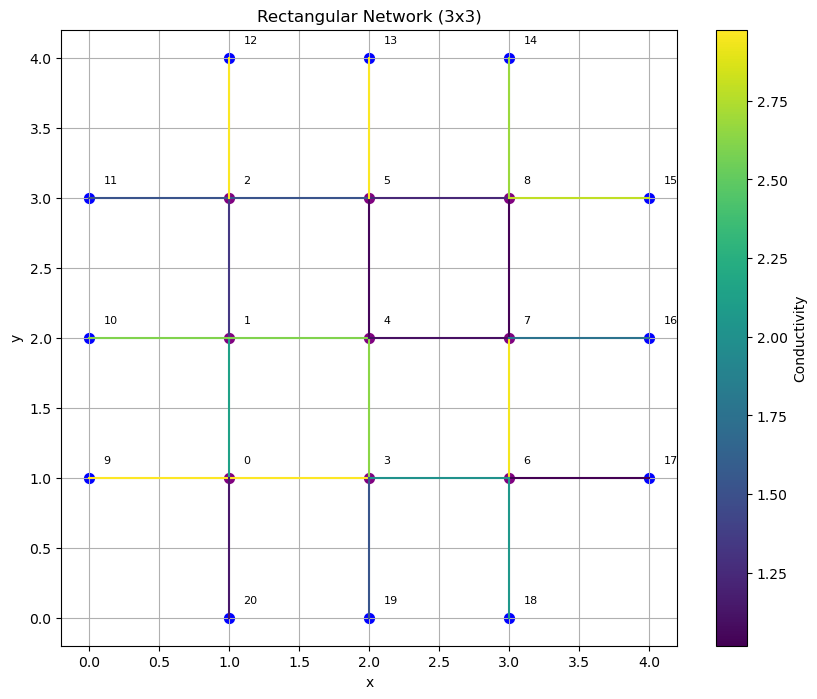

Recovered Conductivity


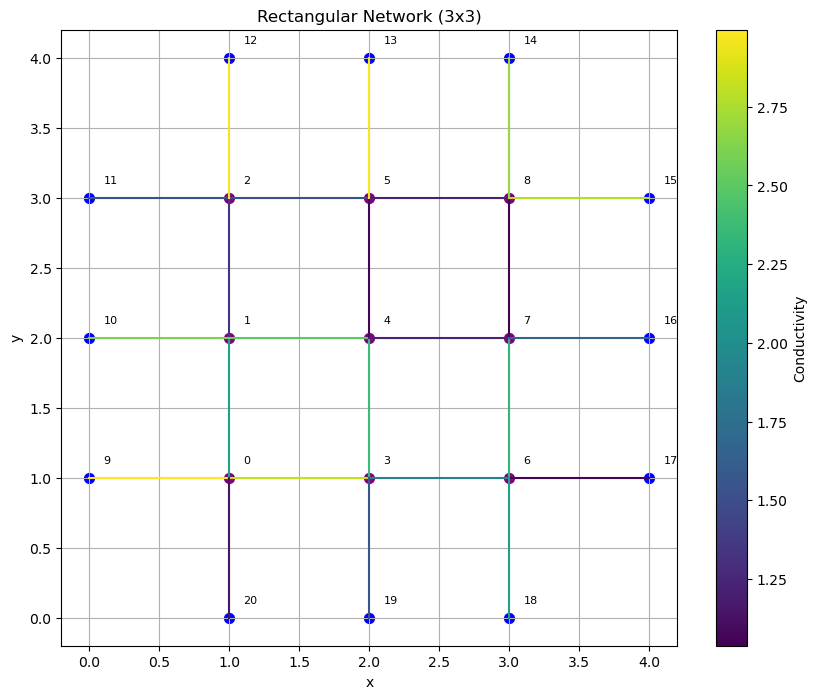



.................................................................................
number of DTN values used =  5
training data used =  tensor([[ 1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  1.7364, -0.3819, -0.0502, -0.0974,
         -0.0878, -0.0308, -0.0320, -0.0897, -0.0667, -0.1352, -0.2878, -0.4769],
        [ 0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000, -0.3819,  1.5544, -0.1288, -0.2499,
         -0.1547, -0.0417, -0.0433, -0.0955, -0.0478, -0.0970, -0.1669, -0.1469],
        [ 0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000, -0.0502, -0.1288,  1.1778, -0.6779,
         -0.1739, -0.0288, -0.0300, -0.0184, -0.0082, -0.0166, -0.0259, -0.0193],
        [ 0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000, -0.09

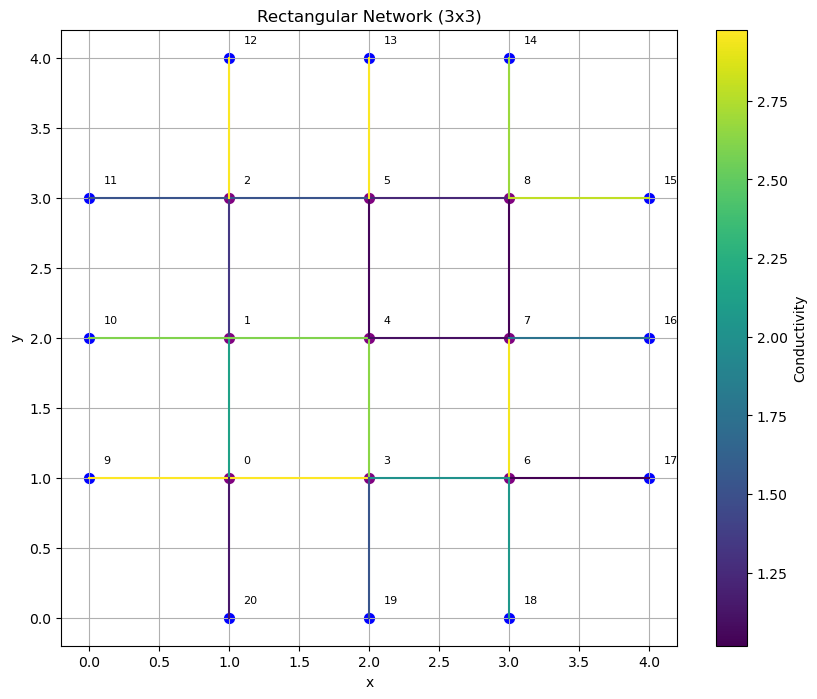

Recovered Conductivity


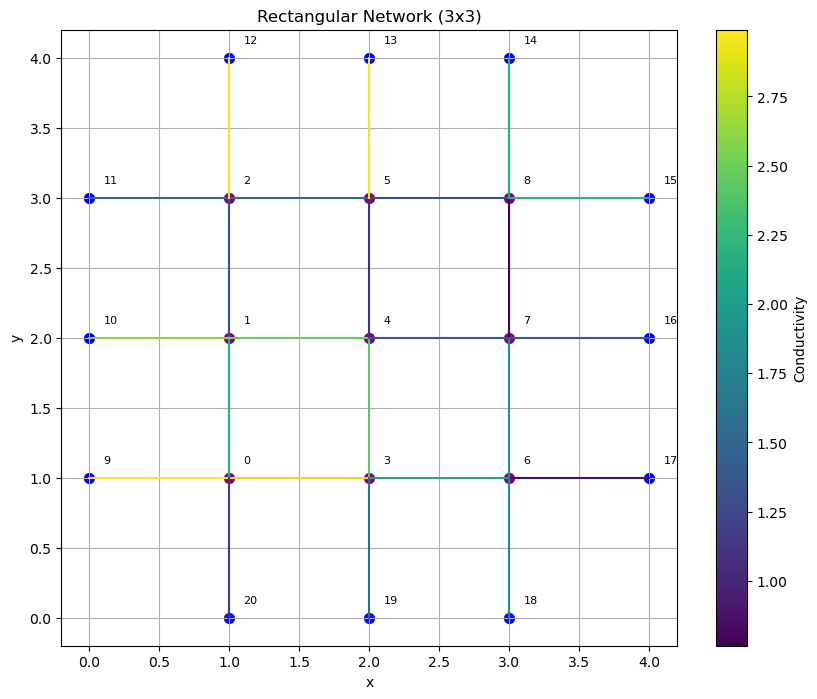



.................................................................................
number of DTN values used =  4
training data used =  tensor([[ 1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  1.7364, -0.3819, -0.0502, -0.0974,
         -0.0878, -0.0308, -0.0320, -0.0897, -0.0667, -0.1352, -0.2878, -0.4769],
        [ 0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000, -0.3819,  1.5544, -0.1288, -0.2499,
         -0.1547, -0.0417, -0.0433, -0.0955, -0.0478, -0.0970, -0.1669, -0.1469],
        [ 0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000, -0.0502, -0.1288,  1.1778, -0.6779,
         -0.1739, -0.0288, -0.0300, -0.0184, -0.0082, -0.0166, -0.0259, -0.0193],
        [ 0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000, -0.09

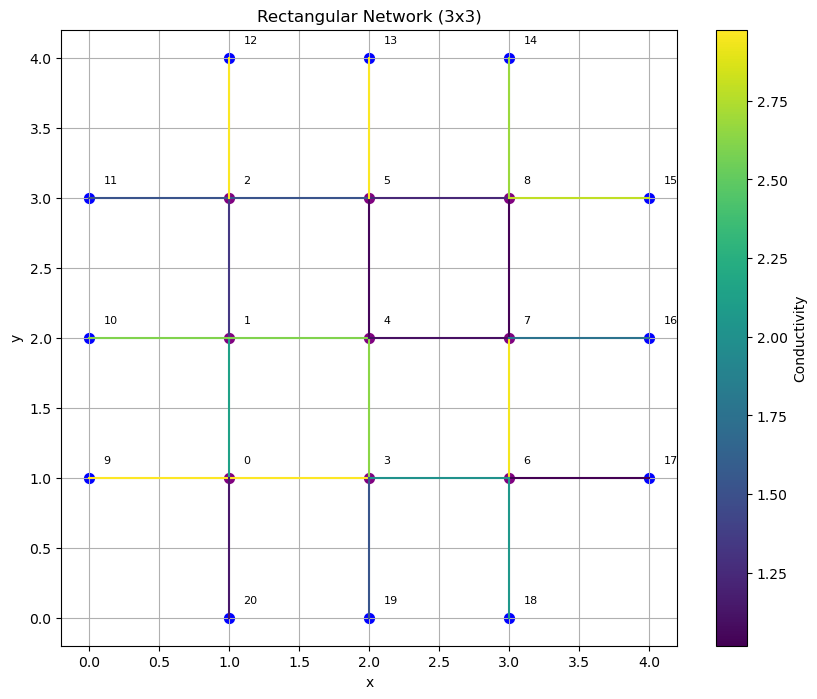

Recovered Conductivity


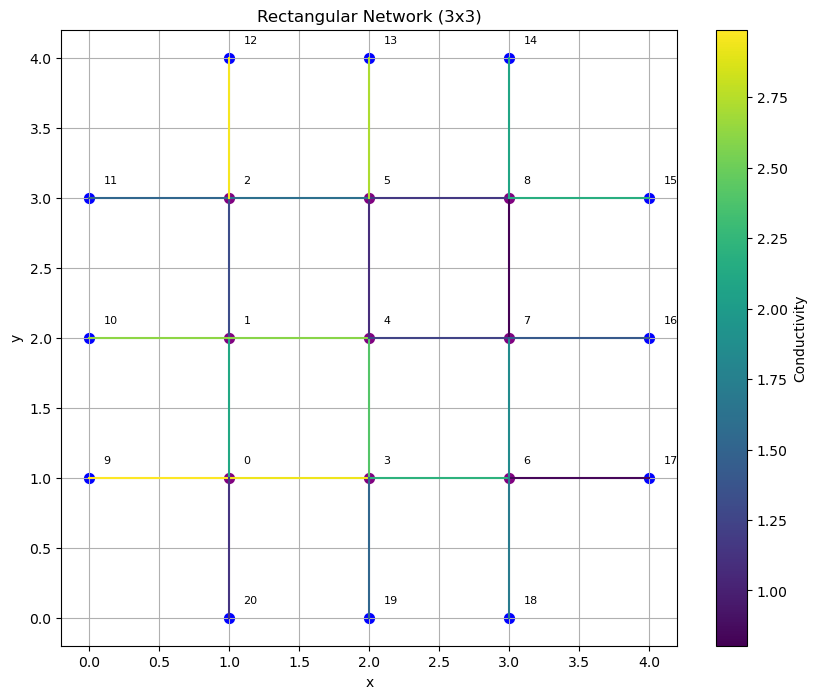



.................................................................................
number of DTN values used =  3
training data used =  tensor([[ 1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  1.7364, -0.3819, -0.0502, -0.0974,
         -0.0878, -0.0308, -0.0320, -0.0897, -0.0667, -0.1352, -0.2878, -0.4769],
        [ 0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000, -0.3819,  1.5544, -0.1288, -0.2499,
         -0.1547, -0.0417, -0.0433, -0.0955, -0.0478, -0.0970, -0.1669, -0.1469],
        [ 0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000, -0.0502, -0.1288,  1.1778, -0.6779,
         -0.1739, -0.0288, -0.0300, -0.0184, -0.0082, -0.0166, -0.0259, -0.0193]],
       dtype=torch.float64)
Epoch [1000/30000], Loss: 9.528933e-03
Epoch [2000/30000], Loss: 3.701373e-04
Epoch [3000/30000], Loss

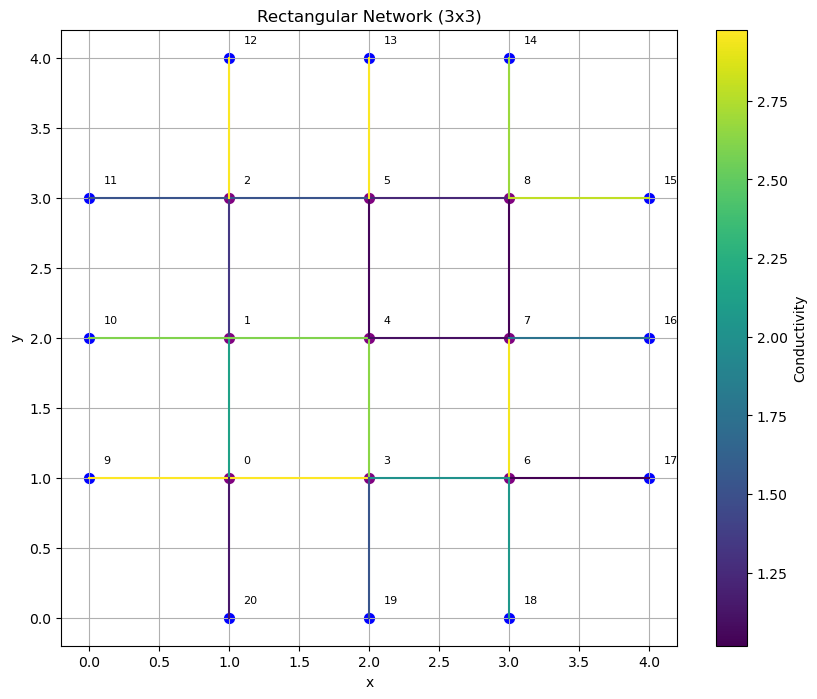

Recovered Conductivity


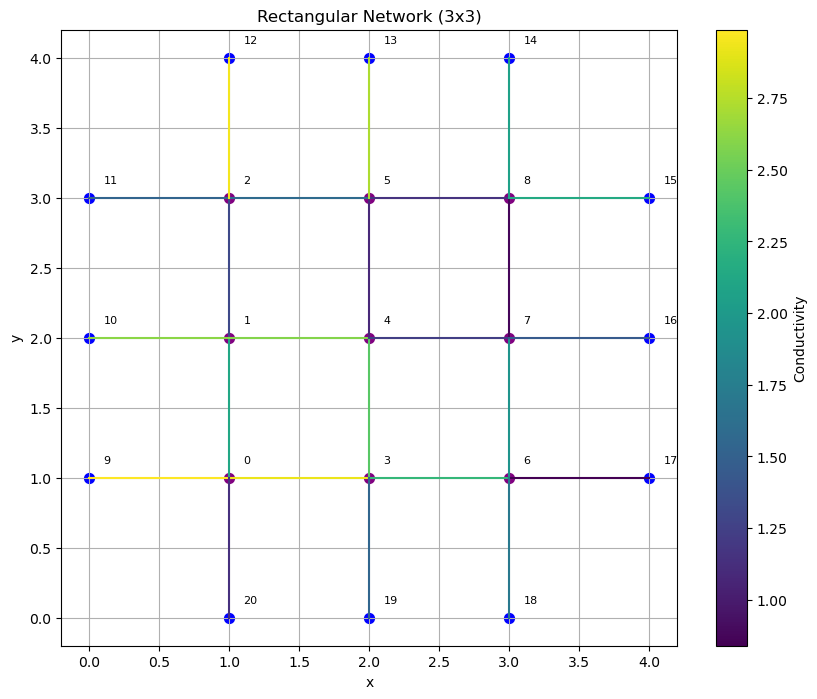



.................................................................................
number of DTN values used =  2
training data used =  tensor([[ 1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  1.7364, -0.3819, -0.0502, -0.0974,
         -0.0878, -0.0308, -0.0320, -0.0897, -0.0667, -0.1352, -0.2878, -0.4769],
        [ 0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000, -0.3819,  1.5544, -0.1288, -0.2499,
         -0.1547, -0.0417, -0.0433, -0.0955, -0.0478, -0.0970, -0.1669, -0.1469]],
       dtype=torch.float64)
Epoch [1000/30000], Loss: 2.595471e-02
Epoch [2000/30000], Loss: 1.840484e-04
Epoch [3000/30000], Loss: 4.072742e-04
Epoch [4000/30000], Loss: 2.789747e-04
Epoch [5000/30000], Loss: 3.661611e-05
Epoch [6000/30000], Loss: 3.376291e-04
Epoch [7000/30000], Loss: 1.023333e-04
Epoch [8000/30000], Loss: 9.366120e-05
Epoch [9000/30000], Loss: 2.345604

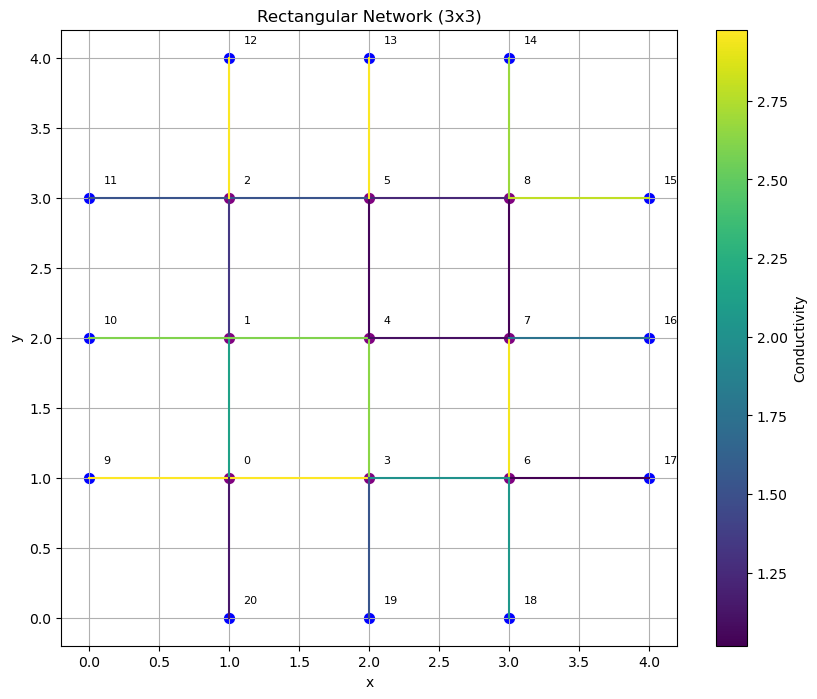

Recovered Conductivity


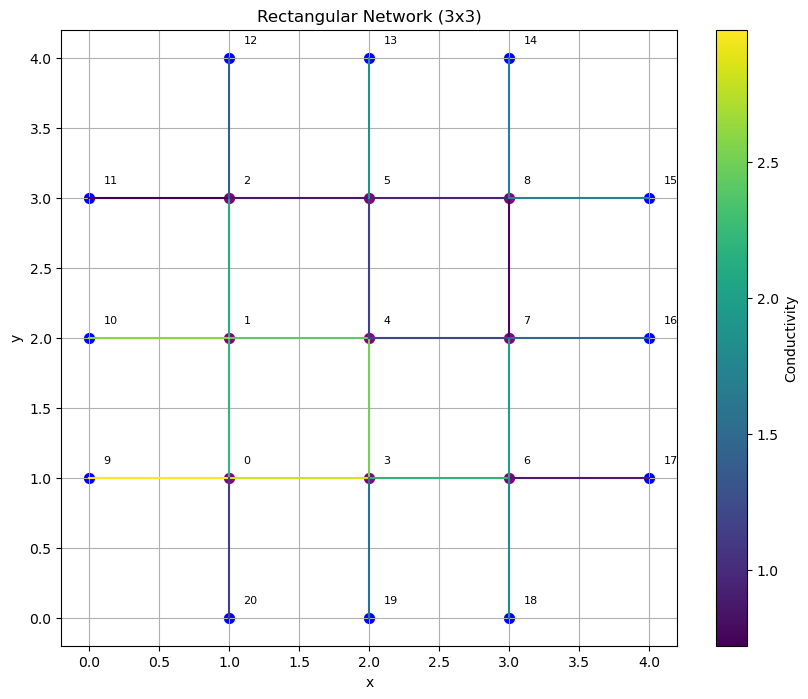



.................................................................................
number of DTN values used =  1
training data used =  tensor([[ 1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  1.7364, -0.3819, -0.0502, -0.0974,
         -0.0878, -0.0308, -0.0320, -0.0897, -0.0667, -0.1352, -0.2878, -0.4769]],
       dtype=torch.float64)
Epoch [1000/30000], Loss: 4.614512e-03
Epoch [2000/30000], Loss: 1.913983e-04
Epoch [3000/30000], Loss: 9.288264e-05
Epoch [4000/30000], Loss: 2.964186e-04
Epoch [5000/30000], Loss: 1.048494e-06
Epoch [6000/30000], Loss: 4.560876e-05
Epoch [7000/30000], Loss: 3.082725e-04
Epoch [8000/30000], Loss: 4.536798e-06
Epoch [9000/30000], Loss: 2.782881e-04
Epoch [10000/30000], Loss: 1.093809e-04
Epoch [11000/30000], Loss: 8.028602e-06
Epoch [12000/30000], Loss: 6.843193e-05
Epoch [13000/30000], Loss: 2.049410e-04
Epoch [14000/30000], Loss: 1.181094e-04
Epoch [15000/30000], Loss: 1.017291e-05

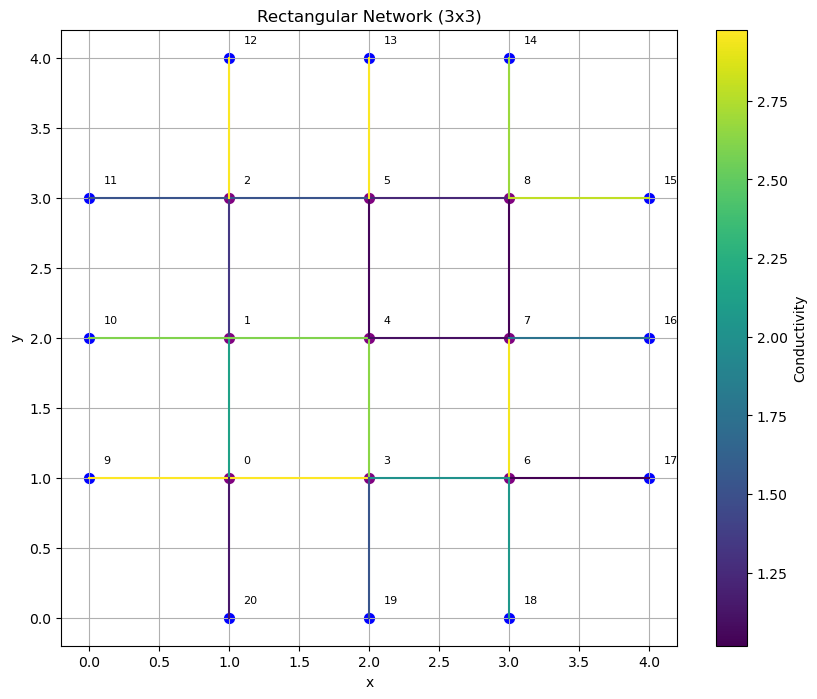

Recovered Conductivity


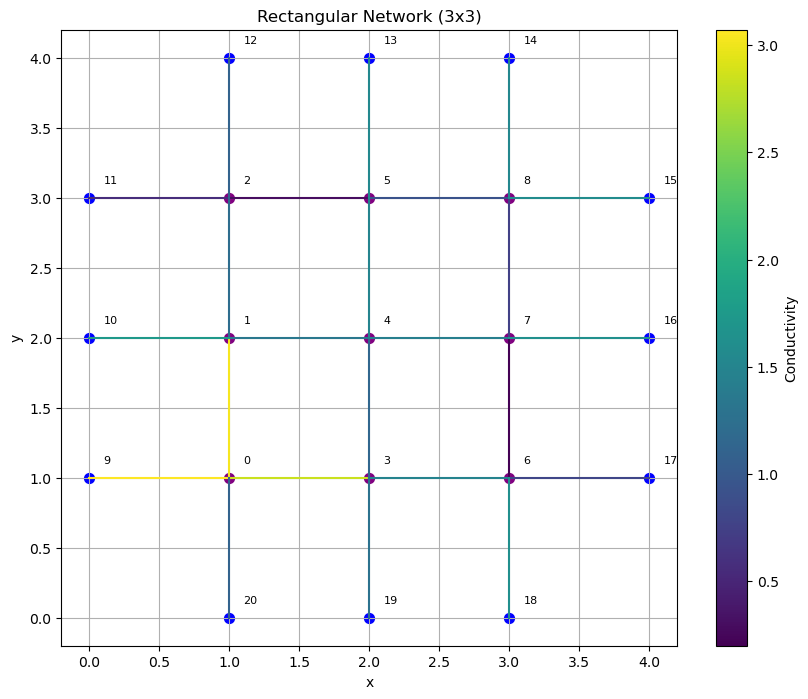



.................................................................................


In [ ]:
# test_low_DTN(3)